# Predicting La Paz Temperature: _Prophet prophet_model_tuned_

In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.serialize import model_to_json
import plotly.express as px
from sklearn.metrics import mean_absolute_error, mean_squared_error
import datetime
import itertools

# retrieve stored variables from Prophet_model-1.pynb
# https://ipython.readthedocs.io/en/stable/config/extensions/storemagic.html
%store -r df
%store -r df_train
%store -r df_test
%store -r test_size
%store -r prophet_model_mae
%store -r prophet_model_rmse
%store -r prophet_model_mean_error
%store -r prophet_model_median_error
%store -r naive_model_mae
%store -r naive_model_rmse
%store -r naive_model_mean_error
%store -r naive_model_median_error
%store -r naive_model_mae
%store -r naive_model_rmse
%store -r naive_model_mean_error
%store -r naive_model_median_error

# Hyperparameter Tuning with Cross Validation
https://facebook.github.io/prophet/docs/diagnostics.html#hyperparameter-tuning

## Cross Validation info
Cross-validation is a technique that is used to evaluate the performance of a model by training it on a subset of the available data and then evaluating it on a different subset. This allows you to assess how well the model will generalize to new, unseen data.

In the case of Facebook Prophet, cross-validation can be used to evaluate the model's forecasting performance by dividing the time series data into training and validation sets, fitting the model on the training set, and then evaluating it on the validation set. This can be done using the cross_validation function in Prophet, which takes the following arguments:

horizon: The forecast horizon, or the number of time points to forecast into the future.

initial: The number of time points to use as a training period.

period: The spacing between the start of each cross-validation fold.

horizon: The forecast horizon, or the number of time points to forecast into the future.

    parallel='processes'
    
For problems that aren’t too big, we recommend using parallel="processes". It will achieve the highest performance when the parallel cross validation can be done on a single machine.
  

# Set the hyperparameters

The Prophet documentation recommends that the following hyperparameters can be tuned: changepoint_prior_scale, seasonality_prior_scale, holidays_prior_scale, and seasonality_mode.

_Changepoint prior scale_ controls the flexibility of the trend, and in particular how much the trend changes at the trend changepoints (there are 25 trend changepoints by default and these are automatically placed)). Larger values allow the trend to change more flexibly, while smaller values penalize trend changes. Default is 0.05 and documentation recommends a range of 0.001, 0.5. 

Set this to 0.001, 0.01, 0.1, 0.5 as recommended in the documentation

_seasonality_prior_scale_ controls how much the model should penalize the inclusion of seasonality in the model. Larger values give more weight to seasonality, while smaller values give less weight. 

As there is no weekly or monthly seasonality this value should be low? The default is 10 which the documentation says applies effectively no regularization, so this value should be set low: 0.01, 0.1, 1, 5, 10? 

_holidays_prior_scale_ controls the flexibility to fit holiday effects. Similar to _seasonality_prior_scale_, it defaults to 10.0 which applies basically no regularization, since we usually have multiple observations of holidays and can do a good job of estimating their effects. This could also be tuned on a range of 0.01, 10. Essentially, this hyperparameter controls how much the model should penalize the inclusion of holidays in the model. Larger values give more weight to holidays, while smaller values give less weight. 

As holidays will not affect the temperature this should be set low? 0.01, 0.1, 1?

_seasonality_mode_ default is additive and so that will be kept as it is.


In [2]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 5.0, 10.0],
    'holidays_prior_scale': [0.01, 0.1, 1, 5, 10] # this should be set to 10 so no regularisation is applied
}

## Key Learning - hyperparameters

- Originally I set the parameters  for 'holidays_prior_scale' as: 0.01, 0.1, 1, 5, 10 and interestingly the best parameters returned an RMSE of 1.65. 
- There were 5 sets of hyperparameters that returned RMSE 1.65. The change_point_prior_scale and seasonality_prior_scale were the same for each set of hyperparameters that returned RMSE 1.65 (0.01 and 0.1 repsectively) and then the holidays_prior_scale values were 0.01, 0.1, 1, 5, 10 .... holidays don't have any influence on the weather - the holidays hyperparameter is for things like sales/memberships/users etc. that might increase or decrease on certain holidays / days such as Black Friday or Labour Day weekend.
- I should have realised this and just given one input (10) for holidays_prior_scale as the docuemntation specifies that a value of 10 (the default value) applies no regularisation and so this is what I should have set and this is confirmed given that the different holidays_prior_scale values returned the same RMSE when the other two hyperparameters were the same.

## Tune the hyperparameters

In [3]:
###### code taken from Prophet documentation #######

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    model = Prophet(**params).fit(df_train)  # Fit model with given params
    df_cv = cross_validation(model, initial='365.25 days', horizon='180 days', parallel="processes") # processes will achieve highest performance when parallel cross validation can be done on a single machine
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

22:25:35 - cmdstanpy - INFO - Chain [1] start processing
22:25:36 - cmdstanpy - INFO - Chain [1] done processing
22:26:00 - cmdstanpy - INFO - Chain [1] start processing
22:26:00 - cmdstanpy - INFO - Chain [1] done processing
22:26:22 - cmdstanpy - INFO - Chain [1] start processing
22:26:23 - cmdstanpy - INFO - Chain [1] done processing
22:26:47 - cmdstanpy - INFO - Chain [1] start processing
22:26:47 - cmdstanpy - INFO - Chain [1] done processing
22:27:08 - cmdstanpy - INFO - Chain [1] start processing
22:27:08 - cmdstanpy - INFO - Chain [1] done processing
22:27:26 - cmdstanpy - INFO - Chain [1] start processing
22:27:26 - cmdstanpy - INFO - Chain [1] done processing
22:27:45 - cmdstanpy - INFO - Chain [1] start processing
22:27:45 - cmdstanpy - INFO - Chain [1] done processing
22:28:04 - cmdstanpy - INFO - Chain [1] start processing
22:28:04 - cmdstanpy - INFO - Chain [1] done processing
22:28:23 - cmdstanpy - INFO - Chain [1] start processing
22:28:23 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.001                     0.01                  0.01   
1                     0.001                     0.01                  0.10   
2                     0.001                     0.01                  1.00   
3                     0.001                     0.01                  5.00   
4                     0.001                     0.01                 10.00   
..                      ...                      ...                   ...   
95                    0.500                    10.00                  0.01   
96                    0.500                    10.00                  0.10   
97                    0.500                    10.00                  1.00   
98                    0.500                    10.00                  5.00   
99                    0.500                    10.00                 10.00   

        rmse  
0   1.673790  
1   1.673790  
2   1.673790  
3  

In [4]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2016-01-02,15.574405,14.049351,17.087420,17.7,2016-01-01
1,2016-01-03,15.664537,14.262891,17.156589,18.1,2016-01-01
2,2016-01-04,15.937345,14.409576,17.426272,13.5,2016-01-01
3,2016-01-05,16.250299,14.767846,17.641654,13.5,2016-01-01
4,2016-01-06,16.211050,14.722025,17.738008,14.7,2016-01-01


In [5]:
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,180 days,5.223045,2.285398,1.73437,0.105869,0.078283,0.100429,0.658213


### Which combination of hyperparameters produced the lowest RMSE and was it better than the naive model?

In [6]:
# get the minimum rmse value
lowest_rmse = min(tuning_results['rmse'])
lowest_rmse

1.6504772410636717

In [7]:
# get the index of the lowest rmse value
lowest_rmse_indices = tuning_results[tuning_results['rmse'] == lowest_rmse].index.tolist()
lowest_rmse_indices

[30, 31, 32, 33, 34]

In [8]:
# check the indices above
tuning_results.iloc[lowest_rmse_indices]

,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,rmse
30,0.01,0.1,0.01,1.650477
31,0.01,0.1,0.10,1.650477
32,0.01,0.1,1.00,1.650477
33,0.01,0.1,5.00,1.650477
34,0.01,0.1,10.00,1.650477


# prophet_model_tuned

Create a model with the the hyperparameters that produced the lowest RMSE value.

In [9]:
# set the hyperparameters
best_params = {'changepoint_prior_scale': 0.01, 
         'seasonality_prior_scale': 0.1, 
          'holidays_prior_scale': 0.01
         }

# instantiate a prophet model based on the results of the hyperparameter tuning
prophet_model_tuned = Prophet(**best_params, 
                  weekly_seasonality=False)

# add monthly seasonality in place of weekly
prophet_model_tuned.add_seasonality(name='monthly', period=30.5, fourier_order=5)

# fit the model to the training data
prophet_model_tuned.fit(df_train)

23:07:40 - cmdstanpy - INFO - Chain [1] start processing
23:07:40 - cmdstanpy - INFO - Chain [1] done processing


### _make_future_dataframe_

The _make_future_dataframe_ method method creates a dataframe with our training data's dates plus the period we specify in the arguments. In this case it'll be 365 days. We'll check this by viewing the tail of the dataframe - the dates should be up to 2022-11-30.

In [10]:
# create a future dataframe that will contain the dates for which we are going to predict
future = prophet_model_tuned.make_future_dataframe(periods=365, freq='D')

# check the end of the dataframe
future.tail()

,ds
2917,2022-11-26
2918,2022-11-27
2919,2022-11-28
2920,2022-11-29
2921,2022-11-30


In [11]:
# check the date the future dataframe goes up to - shpuld be 2022-11-30
future['ds'][-test_size:].tail()

2917   2022-11-26
2918   2022-11-27
2919   2022-11-28
2920   2022-11-29
2921   2022-11-30
Name: ds, dtype: datetime64[ns]

### _predict_

We now have a dataframe (_future_) of dates, the last 365 days of which we are going to predict a value for. The _predict_ method will assign each row a _yhat_ value (predicted value) as well as other data for components and uncertainty intervals. The ouput will be a new dataframe with all of our predictions and associated information.

In [12]:
# use prophet_model_tuned to predict the values by using the predict method
forecast = prophet_model_tuned.predict(future)

# check the last entries for the predictions
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,monthly_lower,monthly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2917,2022-11-26,16.257890,12.523385,16.069305,16.161396,16.345779,-1.911317,-1.911317,-1.911317,0.107026,0.107026,0.107026,-2.018343,-2.018343,-2.018343,0.0,0.0,0.0,14.346573
2918,2022-11-27,16.256759,12.574012,16.197282,16.159889,16.345425,-1.871821,-1.871821,-1.871821,0.172347,0.172347,0.172347,-2.044168,-2.044168,-2.044168,0.0,0.0,0.0,14.384938
2919,2022-11-28,16.255629,12.644809,16.334880,16.158439,16.345071,-1.836473,-1.836473,-1.836473,0.233226,0.233226,0.233226,-2.069699,-2.069699,-2.069699,0.0,0.0,0.0,14.419156
2920,2022-11-29,16.254498,12.649470,16.020335,16.157062,16.344657,-1.853496,-1.853496,-1.853496,0.241503,0.241503,0.241503,-2.095000,-2.095000,-2.095000,0.0,0.0,0.0,14.401002
2921,2022-11-30,16.253368,12.389646,16.004231,16.155631,16.344241,-1.942319,-1.942319,-1.942319,0.177809,0.177809,0.177809,-2.120128,-2.120128,-2.120128,0.0,0.0,0.0,14.311048


# Plot the Forecast and Trend Components

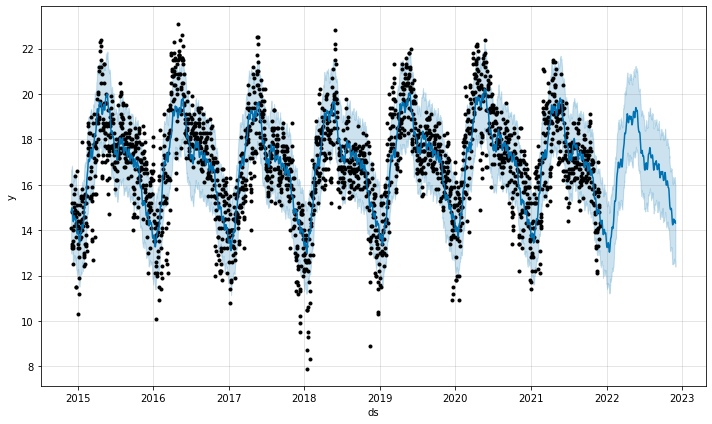

In [13]:
# visualise the forcecast
fig2 = prophet_model_tuned.plot(forecast)

* The black dots are the obsereved values.
* The blue line is the forecast, and the blue shaded areas are the upper and lower bounds.

## Plot Components
By default:
- Prophet fits additive seasonalities, meaning the effect of the seasonality is added to the trend to get the forecast.
- Prophet uses a linear model for its forecast.

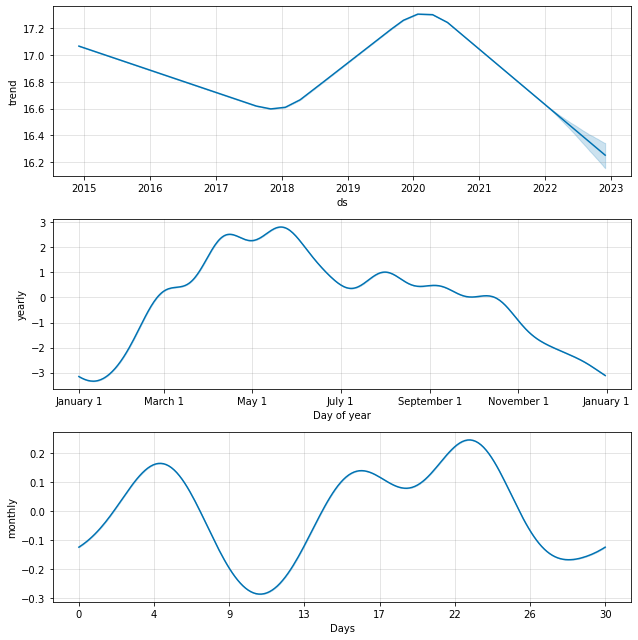

In [14]:
fig2 = prophet_model_tuned.plot_components(forecast)

# prophet_model_tuned: Evaluation

Now let's evaluate prophet_model_tuned on the testing data...

In [15]:
# calculate mean absolute error for prophet_model_tuned
prophet_model_tuned_mae = mean_absolute_error(y_true=df_test['y'], y_pred=forecast['yhat'][-test_size:])
print(f"prophet_model_tuned Mean Absolute Error = {prophet_model_tuned_mae}")

# calculate root of the mean squared error
prophet_model_tuned_rmse = mean_squared_error(y_true=df_test['y'], y_pred=forecast['yhat'][-test_size:], squared=False) # squared=false returns RMSE value
print(f"prophet_model_tuned RMSE = {prophet_model_tuned_rmse}")

# calculate mean error
prophet_model_tuned_yhat = np.array(forecast['yhat'][-test_size:])
prophet_model_tuned_true = np.array(df_test['y'])
residuals = prophet_model_tuned_yhat - prophet_model_tuned_true
prophet_model_tuned_mean_error = np.mean(residuals)
print(f"prophet_model_tuned Mean Error: {prophet_model_tuned_mean_error}")

# calculate median error of model
prophet_model_tuned_median_error = np.median(residuals)
print(f"prophet_model_tuned Median Error: {prophet_model_tuned_median_error}")

prophet_model_tuned Mean Absolute Error = 1.3538104481115991
prophet_model_tuned RMSE = 1.6786902583385879
prophet_model_tuned Mean Error: -0.8938364391887399
prophet_model_tuned Median Error: -0.9484423912008921


## prophet_model_tuned vs. Model 1 vs. Naive Model

In [16]:
# MAE
print(f"prophet_model_tuned MAE vs. Naive model MAE: {prophet_model_tuned_mae - naive_model_mae}")
print(f"prophet_model_tuned MAE vs. Model 1: {prophet_model_tuned_mae - prophet_model_mae}\n\n")

# RMSE
print(f"prophet_model_tuned RMSE vs. Naive model RMSE: {prophet_model_tuned_rmse - naive_model_rmse}")
print(f"prophet_model_tuned RMSE vs. Model 1 RMSE: {prophet_model_tuned_rmse - prophet_model_rmse}\n\n")

# Mean Error
print(f"prophet_model_tuned Mean Error vs. Naive model Mean Error: {prophet_model_tuned_mean_error - naive_model_mean_error}")
print(f"prophet_model_tuned Mean Error vs. Model 1 Mean Error: {prophet_model_tuned_mean_error - prophet_model_mean_error}\n\n")

# Median Error
print(f"prophet_model_tuned Median Error vs. Naive model Median Error: {prophet_model_tuned_median_error - naive_model_median_error}")
print(f"prophet_model_tuned Median Error vs. Model 1 Median Error: {prophet_model_tuned_median_error - prophet_model_median_error}")

prophet_model_tuned MAE vs. Naive model MAE: -0.419888182025387
prophet_model_tuned MAE vs. Model 1: -0.2905984197975624


prophet_model_tuned RMSE vs. Naive model RMSE: -0.4925539402404233
prophet_model_tuned RMSE vs. Model 1 RMSE: -0.3164573314128707


prophet_model_tuned Mean Error vs. Naive model Mean Error: -0.32342548028463025
prophet_model_tuned Mean Error vs. Model 1 Mean Error: 0.47658016880955123


prophet_model_tuned Median Error vs. Naive model Median Error: -0.3484423912008907
prophet_model_tuned Median Error vs. Model 1 Median Error: 0.471971441813805


In [17]:
comparison_data = {'model': ['Naive_model', 'prophet_model', 'prophet_model_tuned'], 
                  'MAE': [naive_model_mae, prophet_model_mae, prophet_model_tuned_mae],
                  'RMSE': [naive_model_rmse, prophet_model_rmse, prophet_model_tuned_rmse], 
                  'Mean Error': [naive_model_mean_error, prophet_model_mean_error, prophet_model_tuned_mean_error],
                  'Median Error': [naive_model_median_error, prophet_model_median_error, prophet_model_tuned_median_error]}

df_comparison = pd.DataFrame(data=comparison_data)
df_comparison.set_index('model', inplace=True)
df_comparison

,MAE,RMSE,Mean Error,Median Error
model,,,,
Naive_model,1.773699,2.171244,-0.570411,-0.600000
prophet_model,1.644409,1.995148,-1.370417,-1.420414
prophet_model_tuned,1.353810,1.678690,-0.893836,-0.948442


So, prophet_model_tuned makes predictions that are, on average, 0.53 degrees celsius and 0.34 degrees celsius better than the naive and model 1 respectively.

# Save the model

In [18]:
# save the model
with open('../Models/prophet_model-2.json', 'w') as fout:
    fout.write(model_to_json(prophet_model_tuned))

# Next steps
1. Add more data to train on to see if this can improve the model?
2. Review the Hyperparameter training process - add cutoffs parameter and alter horizon?

### Store variables for use in other Jupyter Notebooks

In [19]:
# store variables so they can be used in other notebooks
%store prophet_model_tuned_mae
%store prophet_model_tuned_rmse

Stored 'prophet_model_tuned_mae' (float64)
Stored 'prophet_model_tuned_rmse' (float64)


## Next Steps

Set the horizon to 30 days (vs. 180 days in attempt 1) and specify the training period as 180 days (but keep the initial training period as 365 days).